# Experiment Template


**In this notebook:**

* Load original mri data + aneurysm mask
* Resample Images to 1.5 mm Voxelsize
* Filter images based on size
* Train network to predict vessel mask
* Evaluate aneurysm mask

**Todo:**
* Check percentage of 1s in resampled mask
* Write evaluation
* Try out different batch_sizes

## Dependencies
Install, load, and initialize all required dependencies for this experiment.

### Install Dependencies

In [1]:
#It should be possible to run the notebook independent of anything else. 
# If dependency cannot be installed via pip, either:
# - download & install it via %%bash
# - atleast mention those dependecies in this section

import sys
!{sys.executable} -m pip install -q -e ../../utils/


You should consider upgrading via the '/group/cake/leo/.venv/bin/python -m pip install --upgrade pip' command.


In [2]:
!{sys.executable} -m pip install tqdm


You should consider upgrading via the '/group/cake/leo/.venv/bin/python -m pip install --upgrade pip' command.


In [3]:
x =5
a = x
del a 
print(x)

5


### Import Dependencies

# System libraries

In [2]:
from __future__ import absolute_import, division, print_function
import logging, os, sys

# Enable logging
logging.basicConfig(format='[%(levelname)s] %(message)s', level=logging.INFO, stream=sys.stdout)

# Re-import packages if they change
%load_ext autoreload
%autoreload 2

# Recursion Depth
import sys
sys.setrecursionlimit(10000)

# Intialize tqdm to always use the notebook progress bar
import tqdm
tqdm.tqdm = tqdm.tqdm_notebook

# Third-party libraries
import comet_ml
import numpy as np
import pandas as pd
import nilearn.plotting as nip
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import collections

import git


# Project utils

import aneurysm_utils
from aneurysm_utils import evaluation, training
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,6)
%config InlineBackend.figure_format='retina'  # adapt plots for retina displays

/group/cake/markus/.venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [3]:
if "workspace" in os.getcwd():
    ROOT = "/workspace"
elif "/group/cake" in os.getcwd(): 
    ROOT = "/group/cake"


### Initialize Environment

In [4]:
env = aneurysm_utils.Environment(project="our-git-project", root_folder=ROOT)
env.cached_data["comet_key"] = "EGrR4luSis87yhHbs2rEaqAWs" 
env.print_info()

Environment Info:

Library Version: 0.1.0
Configured Project: our-git-project

Folder Structure: 
- Root folder: /group/cake
 - Project folder: /group/cake/our-git-project
 - Datasets folder: /data/training
 - Models folder: /group/cake/our-git-project/models
 - Experiments folder: /group/cake/our-git-project/experiments


## Load Data
Download, explore, and prepare all required data for the experiment in this section.

dataset_params = {
    "prediction": "vessel",
    "mri_data_selection": "", 
    "balance_data": False,
    "seed": 1,
     "resample_voxel_dim": (1.2,1.2,1.2)
    #"resample_size":(93,93,80)
    
}

preprocessing_params = {
    'min_max_normalize': True,
    'mean_std_normalize': False,
    'smooth_img': False, # can contain a number: smoothing factor
    'intensity_segmentation': None
}


### Load Meta Data

### Load & Split MRI Data

# Load MRI images and split into train, test, and validation
from aneurysm_utils.data_collection import split_mri_images
# case_list = ["A009","A010","A012","A016","A014","A015"]
# df = df.loc[df["Case"].isin(case_list)]

train_data, test_data, val_data, _ = split_mri_images(
    env, 
    df, 
    prediction=dataset_params["prediction"], 
    encode_labels=False,
    random_state=dataset_params["seed"],
    balance_data=dataset_params["balance_data"],
    resample_voxel_dim=dataset_params["resample_voxel_dim"],
    #resample_size=dataset_params["resample_size"]
)
print(len(train_data))
mri_imgs_train, labels_train_vessel,_ = train_data
mri_imgs_test, labels_test_vessel,_ = test_data
mri_imgs_val, labels_val_vessel,_ = val_data

mri_imgs_train= [img *mask for img,mask in zip(mri_imgs_train,labels_train_vessel)]
mri_imgs_test= [img *mask for img,mask in zip(mri_imgs_test,labels_test_vessel)]
mri_imgs_val= [img *mask for img,mask in zip(mri_imgs_val,labels_val_vessel)]

del labels_train_vessel,labels_test_vessel,labels_val_vessel

from aneurysm_utils.data_collection import load_aneurysm_dataset

df = load_aneurysm_dataset(
    env,
    mri_data_selection=dataset_params["mri_data_selection"],
    random_state=dataset_params["seed"]
)
df.head()

In [5]:
dataset_params = {
    "prediction": "mask",
    "mri_data_selection": "", 
    "balance_data": False,
    "seed": 1,
    "resample_voxel_dim": (1.2,1.2,1.2),
    #"resample_size":(93,93,80)
    
}

preprocessing_params = {
    'min_max_normalize': True,
    'mean_std_normalize': False,
    'smooth_img': False, # can contain a number: smoothing factor
    'intensity_segmentation': 0.2
}

from aneurysm_utils.data_collection import load_aneurysm_dataset

df = load_aneurysm_dataset(
    env,
    mri_data_selection=dataset_params["mri_data_selection"],
    random_state=dataset_params["seed"]
)
df.head()

# Load MRI images and split into train, test, and validation
from aneurysm_utils.data_collection import split_mri_images
# case_list = ["A009","A010","A012","A016","A014","A015"]
# df = df.loc[df["Case"].isin(case_list)]

train_data, test_data, val_data, _ = split_mri_images(
    env, 
    df, 
    prediction=dataset_params["prediction"], 
    encode_labels=False,
    random_state=dataset_params["seed"],
    balance_data=dataset_params["balance_data"],
    resample_voxel_dim=dataset_params["resample_voxel_dim"],
    #resample_size=dataset_params["resample_size"]
)

mri_imgs_train, labels_train,_  = train_data
mri_imgs_test, labels_test,_  = test_data
mri_imgs_val, labels_val,_  = val_data



109
98
         Images
-----  --------
All         109
Train        87
Val          11
Test         11



  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [8]:

#evaluation.draw_image(mri_imgs_train[2])

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


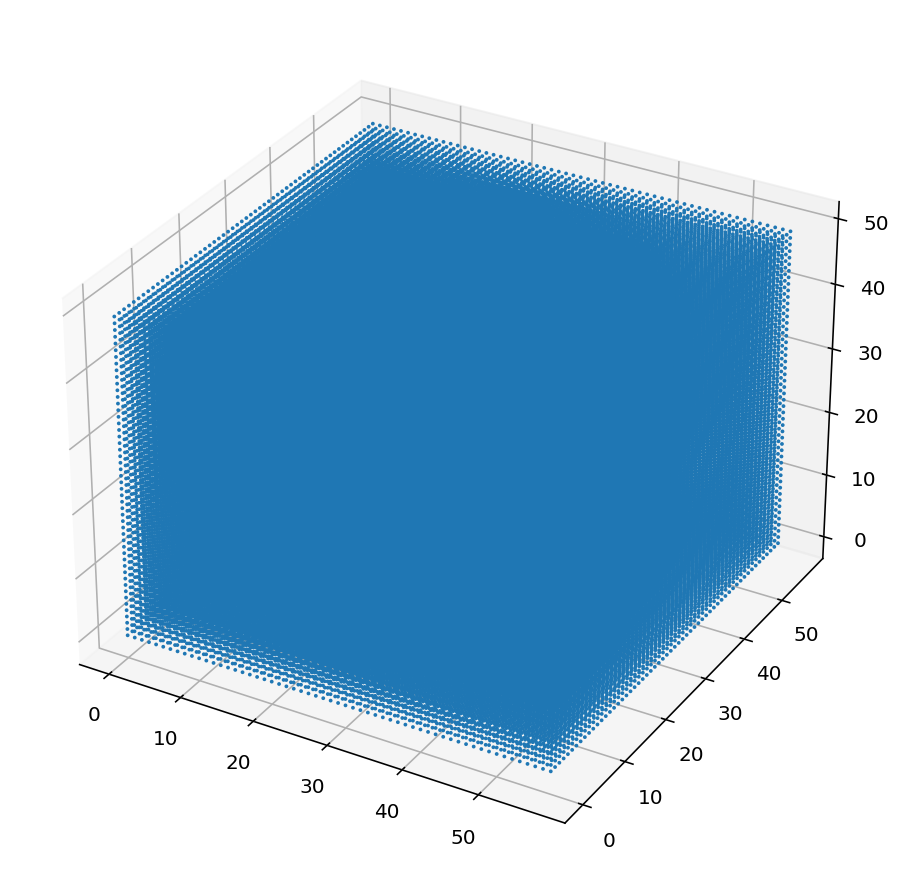

In [9]:
from aneurysm_utils import evaluation,preprocessing
evaluation.draw_mask_3d(np.where(mri_imgs_train[10]>0,1,0))

In [10]:
for image in mri_imgs_train:
    print(np.count_nonzero(image))

1344544
1344523
1344012
1344770
1343205
1345568
1344922
1342958
1343344
1343890
168012
1343389
1344100
1344385
1344765
1344653
1345280
1342358
1345450
174033
1343963
1345352
1343267
1344990
1344878
1344186
1343818
1343785
1345356
1345393
1344473
1344139
1344478
1344678
1343859
1343797
1345197
1343282
1344661
1344142
1344234
1345597
1345059
1345324
1345574
1344361
1343314
1345322
1345100
1345203
1344710
1343460
1345382
1345538
1344871
173662
1345462
1344602
1344610
1344858
1344628
1345260
1344553
647170
1343073
1341715
1344961
1345149
1343075
1334921
1345287
1344475
1343349
1344612
1345009
1343567
1343310
1343339
1344649
174042
1344878
167854
1344033
1343052
646496
1345213
1344475


In [11]:
print(mri_imgs_train[0].shape)

(116, 116, 100)


In [6]:
from aneurysm_utils import preprocessing

most_common_shape=preprocessing.check_mri_shapes(mri_imgs_train)
print(most_common_shape)


Most common:
(116, 116, 100):      80
(59, 59, 50):       3
(58, 58, 50):       2
(90, 90, 80):       2
(116, 116, 100)


## Transform & Preprocess Data

In [7]:
from aneurysm_utils import preprocessing

size_of_train = len(mri_imgs_train)
size_of_test = len(mri_imgs_test)
size_of_val = len(mri_imgs_val)

# preprocess all lists as one to have a working mean_std_normalization
mri_imgs = mri_imgs_train + mri_imgs_test + mri_imgs_val
mri_imgs = preprocessing.preprocess(env, mri_imgs, preprocessing_params)

mri_imgs_train = mri_imgs[:size_of_train]
mri_imgs_train = [train for train in mri_imgs_train]
mri_imgs_test = mri_imgs[size_of_train : size_of_train + size_of_test]
mri_imgs_test = [test for test in mri_imgs_test]
mri_imgs_val = mri_imgs[size_of_train + size_of_test :]
mri_imgs_val = [val for val in mri_imgs_val]

# preprocess mask
x, y, h = labels_train[0].shape
labels_train = [label_train for label_train in labels_train]
labels_test = [label_test for label_test in labels_test]
labels_val = [label_val for label_val in labels_val]
# flatten

[INFO] Preprocessing: Min Max Normalize...
[INFO] Preprocessing: Intensity Segmentation...


In [8]:
size = (116, 116, 100)#(93, 93, 80)  #(139, 139, 120)#(47,47,41)#
print(size)
train_index = [i for i, e in enumerate(mri_imgs_train) if e.shape != size]
mri_imgs_train = [i for j, i in enumerate(mri_imgs_train) if j not in train_index]
labels_train = [i for j, i in enumerate(labels_train) if j not in train_index]

test_index = [i for i, e in enumerate(mri_imgs_test) if e.shape != size]
mri_imgs_test = [i for j, i in enumerate(mri_imgs_test) if j not in test_index]
labels_test = [i for j, i in enumerate(labels_test) if j not in test_index]

val_index = [i for i, e in enumerate(mri_imgs_val) if e.shape != size]
mri_imgs_val = [i for j, i in enumerate(mri_imgs_val) if j not in val_index]
labels_val = [i for j, i in enumerate(labels_val) if j not in val_index]

mri_imgs_train[0].shape
preprocessing.check_mri_shapes(mri_imgs_train)
print(np.unique(labels_val[0], return_counts=True))


(116, 116, 100)
Most common:
(116, 116, 100):      80
(array([0., 1.], dtype=float32), array([1345540,      60]))


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [16]:
for image in mri_imgs_train:
    print(np.count_nonzero(image))

2177
2968
6406
4658
5369
2060
6789
3746
2390
2932
3959
1551
2238
3274
1858
2309
3943
4615
2956
2753
2309
1857
5067
3499
3214
4622
7149
4671
1633
3442
6516
5503
5459
3584
3257
4542
1231
7520
3515
9944
6598
3972
2556
3701
3760
5608
3771
2304
1127
12201
4955
16923
3815
4818
4566
4098
4950
4991
8154
5848
9215
6474
928
4277
4364
15653
2300
1746
2959
2822
2798
2840
2869
2958
3540
5680
3037
18382
7078
1825


Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


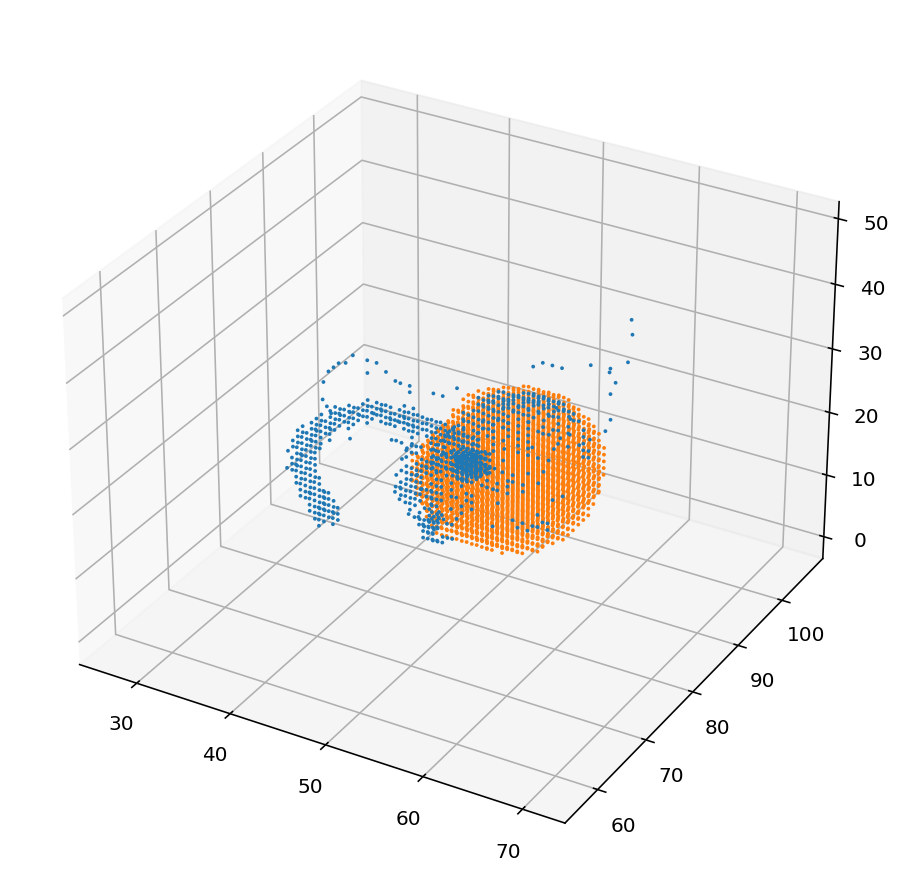

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

In [17]:
from aneurysm_utils import evaluation,preprocessing
fig = plt.figure()
ax = Axes3D(fig)
evaluation.draw_mask_3d(np.where(mri_imgs_train[-18]>0,1,0),ax=ax)
evaluation.draw_mask_3d(labels_train[-18],ax=ax)

## Train Model
Implementation, configuration, and evaluation of the experiment.

### Train Deep Model 3D data

In [9]:
from comet_ml import Optimizer

artifacts = {
    "train_data": (mri_imgs_train, labels_train),
    "val_data": (mri_imgs_val, labels_val),
    "test_data": (mri_imgs_test, labels_test)
}

# Define parameter configuration for experiment run
# params = {
#     "batch_size": 3,
#     "epochs": 10,
#     "es_patience": None, # None = deactivate early stopping
#     "model_name": 'SegNet',
#     "optimizer_momentum": 0.9,
#     "optimizer":'Adam',
#     "learning_rate": 0.0001,
#     "criterion": "CrossEntropyLoss",
#     "sampler": None,   #'ImbalancedDatasetSampler2',
#     "shuffle_train_set": True,
#     "save_models": False,
#     "criterion_weights": [1.0, 1000.0],
#     "debug": True,
#     "weight_decay":0.01
# }
params = {
    "batch_size": 2,
    "epochs": 150,
    "learning_rate": 1.0e-4, # 3e-04, 1.0E-5
    "es_patience": None, # None = deactivate early stopping
    "weight_decay": 0.001, # 1e-3
    "model_name": 'SegNet',
    "optimizer_momentum": 0.9,
    "optimizer":'Adam',
    "criterion": "CrossEntropyLoss", 
    "criterion_weights": [1.0, 1.0], # [1.75, 1.0],
    "sampler": None,   #'ImbalancedDatasetSampler2',
    "shuffle_train_set": True,
    "save_models":True,
    "scheduler": "ReduceLROnPlateau", # "ReduceLROnP
    "debug":False,
    "dropout":0.2,
    "start_radius":0.2*int(most_common_shape[0]),
    "save_models":True,
    "process": True,
    
}
params.update(dataset_params)
params.update(preprocessing_params)
config = {
    # We pick the Bayes algorithm:
    "algorithm": "bayes",
    # Declare your hyperparameters in the Vizier-inspired format:
    "parameters": {
        #"criterion_weights": {"type": "integer", "scalingType": "loguniform", "min": 1, "max": 10},
        #"weight_decay": {"type": "float", "scalingType": "loguniform", "min": 1e-10, "max": 1e-3},
        "learning_rate": {"type": "float", "scalingType": "loguniform", "min": 1e-4, "max": 1e2},
        #"scheduler": {"type": "categorical", "values": ["ReduceLROnPlateau", ""],},
        #"start_radius":{"type":"float","scalingType":"loguniform","min":0.1, "max":0.2},
    },
    # Declare what we will be optimizing, and how:
    "spec": {"metric": "bal_acc", "objective": "maximize"},  #test balance accuracy
}


opt = Optimizer(config, api_key=env.cached_data["comet_key"])

COMET INFO: COMET_OPTIMIZER_ID=006abba5defe4a06a922a1069d1e95fd
COMET INFO: Using optimizer config: {'algorithm': 'bayes', 'configSpaceSize': 'infinite', 'endTime': None, 'id': '006abba5defe4a06a922a1069d1e95fd', 'lastUpdateTime': None, 'maxCombo': 0, 'name': '006abba5defe4a06a922a1069d1e95fd', 'parameters': {'learning_rate': {'max': 100.0, 'min': 0.0001, 'scalingType': 'loguniform', 'type': 'float'}}, 'predictor': None, 'spec': {'gridSize': 10, 'maxCombo': 0, 'metric': 'bal_acc', 'minSampleSize': 100, 'objective': 'maximize', 'retryAssignLimit': 0, 'retryLimit': 1000}, 'startTime': 15018640755, 'state': {'mode': None, 'seed': None, 'sequence': [], 'sequence_i': 0, 'sequence_pid': None, 'sequence_retry': 0, 'sequence_retry_count': 0}, 'status': 'running', 'suggestion_count': 0, 'trials': 1, 'version': '2.0.1'}


In [10]:

import gc
gc.collect()

47

In [ ]:
# Finally, get experiments, and train your models:
import time
for comet_exp in opt.get_experiments(project_name=env.project):
    print(comet_exp)
    param_copy = params.copy()
    comet_exp.params
    
    #param_copy["weight_decay"] = comet_exp.get_parameter("weight_decay")
    #param_copy["criterion_weights"] = comet_exp.get_parameter("criterion_weights")
    param_copy["learning_rate"] = comet_exp.get_parameter("learning_rate")
    #param_copy["scheduler"] = comet_exp.get_parameter("scheduler")

    exp = env.create_experiment(
        params["prediction"] + "-pytorch-" + params["model_name"], comet_exp
    ) #params["selected_label"] + "-hyperopt-" + params["model_name"]
    exp.run(training.train_pytorch_model, param_copy, artifacts)
    
    time.sleep(3)
    del exp
    import gc
    gc.collect()


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rbendias/our-git-project/3799dc63d0a04fcbbff5dcdf59a0da0e



[INFO] Experiment mask-pytorch-SegNet is initialized.
[INFO] Running experiment: 2021-07-14-17-14-47_mask-pytorch-segnet
Number of Classes 2
Selected model: SegNet
Processing...
Done!
Processing...
Done!
Processing...
Done!
[INFO] Train dataset loaded. Length: 80
[INFO] Validation dataset loaded. Length: 11
[INFO] Engine run starting with max_epochs=150.


Argument save_interval is deprecated and should be None. This argument will be removed in 0.5.0.Please, use events filtering instead, e.g. Events.ITERATION_STARTED(every=1000)


[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:03
[INFO] Learning rate: 0.004820214845278156
[INFO] Engine run complete. Time taken: 00:00:03
[INFO] Training Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.25
RAM memory % used: 21.9
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Learning rate: 0.004820214845278156
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.29
RAM memory % used: 21.9
[INFO] Epoch[1] Complete. Time taken: 00:00:10
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:02
[INFO] Learning rate: 0.004820214845278156
[INFO] Engine run complete. Time taken: 00:00:02
[INFO] Training Results - Epoch: 2 Bal Avg accuracy: 0.50 Avg loss: 0.31
RAM memory % used: 21.9
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Learn

# Run experiment and sync all metadata
exp = env.create_experiment(
    params["prediction"] + "-pytorch-" + params["model_name"],
    comet_ml.Experiment(
        env.cached_data["comet_key"],
        project_name=env.project + "-" + params["prediction"],
        disabled=params["debug"],
    ),
)
exp.run(training.train_pytorch_model, params, artifacts)

## Evaluate Model

Do evaluation, e.g. visualizations  

In [ ]:
from aneurysm_utils.utils.pytorch_utils import predict

In [ ]:
model = exp.artifacts["model"]

In [ ]:
predictions = predict(model, mri_imgs_val, apply_softmax=False )

In [ ]:
predictions[0][1]

In [ ]:

idx = 0
nip.view_img(
    nib.Nifti1Image(predictions[0][0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)

In [ ]:
idx = 0
nip.view_img(
    nib.Nifti1Image(labels_val[0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)